## Store item demand forcast

### 1.0 Import library

In [3]:
# Import library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
import gc
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
import lightgbm as lgb
plt.style.use('ggplot')
%matplotlib inline
seed = 433

### 1.2 Load dataset

In [4]:
#path ='dataset/'
import os
os.chdir("C://Users//rohan//Desktop//Supply-chain//Dataset")
train = pd.read_csv('train.csv',parse_dates=[0],nrows=None)
test = pd.read_csv('test.csv',parse_dates=[1], nrows=None )
print('Number of rows and columns in train dataset are:',train.shape)
print('Number of rows and columns in test dataset are:', test.shape)

Number of rows and columns in train dataset are: (913000, 4)
Number of rows and columns in test dataset are: (45000, 4)


### 1.3 Useful function

In [5]:
def basic_details(df):
    """Find number of missing value,dtyeps, unique value in 
    dataset"""
    k = pd.DataFrame()
    k['Missing value'] = df.isnull().sum()
    k['% Missing value'] = df.isnull().sum()/df.shape[0]
    k['dtype'] = df.dtypes
    k['N unique'] = df.nunique()
    return k

In [6]:
def agg_stats(df,statistics,groupby_column):
    """Aggregate a column by unit sales statistics such as 
    'mean','sum','min','max', 'var', 'std',"""
    f,ax = plt.subplots(3,2,figsize=(14,8))
    ax =ax.ravel()
    for i,s in enumerate(statistics):
        tmp = (df
         .groupby(groupby_column)
         .agg({'sales':s})
         )
        tmp.columns = ['sales_{}'.format(s)]
        sns.lineplot(x=tmp.index, y = tmp.iloc[:,0],color='blue',ax=ax[i])
        ax[i].set_xticks(tmp.index)
        for ticks in ax[i].get_xticklabels(): ticks.set_rotation(90)
        #plt.xticks(rotation=90)
        ax[i].set_title('sales_{}'.format(s))
        ax[i].set_ylabel('')
    plt.tight_layout()

In [7]:
### date_time_feat
def date_time_feat(df,column):
    "Extract date time feature"
    df['day'] = df[column].dt.day
    df['dayofweek'] = df[column].dt.dayofweek
    df['month'] = df[column].dt.month
    df['year'] = df[column].dt.year
    
    df['is_month_end'] = df[column].dt.is_month_end.astype('int8')
    df['is_month_start'] = df[column].dt.is_month_start.astype('int8')
    df['weekofyear'] = df[column].dt.weekofyear
    # conver to category
    #df['dayofweek'] = pd.Categorical(df['dayofweek'],
     #       categories=['Monday','Tuesday', 'Wednesday', 'Thursday', 'Friday','Saturday', 'Sunday',])


In [8]:
# Reduce memory of dataset
def reduce_memory_usage(df):
    """ The function will reduce memory of dataframe """
    intial_memory = df.memory_usage().sum()/1024**2
    print('Intial memory usage:',intial_memory,'MB')
    for col in df.columns:
        mn = df[col].min()
        mx = df[col].max()
        if df[col].dtype != object:            
            if df[col].dtype == int:
                if mn >=0:
                    if mx < np.iinfo(np.uint8).max:
                        df[col] = df[col].astype(np.uint8)
                    elif mx < np.iinfo(np.uint16).max:
                        df[col] = df[col].astype(np.uint16)
                    elif mx < np.iinfo(np.uint32).max:
                        df[col] = df[col].astype(np.uint32)
                    elif mx < np.iinfo(np.uint64).max:
                        df[col] = df[col].astype(np.uint64)
                else:
                    if mn > np.iinfo(np.int8).min and mx < np.iinfo(np.int8).max:
                        df[col] = df[col].astype(np.int8)
                    elif mn > np.iinfo(np.int16).min and mx < np.iinfo(np.int16).max:
                        df[col] = df[col].astype(np.int16)
                    elif mn > np.iinfo(np.int32).min and mx < np.iinfo(np.int32).max:
                        df[col] = df[col].astype(np.int32)
                    elif mn > np.iinfo(np.int64).min and mx < np.iinfo(np.int64).max:
                        df[col] = df[col].astype(np.int64)
            if df[col].dtype == float:
                df[col] =df[col].astype(np.float32)
    
    red_memory = df.memory_usage().sum()/1024**2
    print('Memory usage after complition: ',red_memory,'MB')

## 2.0 Exploratory data analysis
Glimpse dataset

In [9]:
train.head()

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


In [10]:
test.head()

,id,date,store,item
0,0,2018-01-01,1,1
1,1,2018-01-02,1,1
2,2,2018-01-03,1,1
3,3,2018-01-04,1,1
4,4,2018-01-05,1,1


The test dataset contains id column but train dataset does not contains id column. While importing dataset parse_date is assigned with perticular column index.

In [11]:
basic_details(test) # test dataset

,Missing value,% Missing value,dtype,N unique
id,0,0.0,int64,45000
date,0,0.0,datetime64[ns],90
store,0,0.0,int64,10
item,0,0.0,int64,50


In [12]:
train.describe() # descriptive statistics about features

,store,item,sales
count,913000.000000,913000.000000,913000.000000
mean,5.500000,25.500000,52.250287
std,2.872283,14.430878,28.801144
min,1.000000,1.000000,0.000000
25%,3.000000,13.000000,30.000000
50%,5.500000,25.500000,47.000000
75%,8.000000,38.000000,70.000000
max,10.000000,50.000000,231.000000


There are 50 diffirent item in 10 diffirent stores. The maximum number of items sold is 231 and average item sold is 52.25.

### 2.1 Date
Let's extract day, week, month, year from date feature

In [13]:
print('Time series start time: "{}" and end time: "{}"'.format(train['date'].min(), train['date'].max()))
print('Time series start time: "{}" and end time: "{}"'.format(test['date'].min(), test['date'].max()))

Time series start time: "2013-01-01 00:00:00" and end time: "2017-12-31 00:00:00"
Time series start time: "2018-01-01 00:00:00" and end time: "2018-03-31 00:00:00"


In [14]:
# Generate date time feature
date_time_feat(train,'date')
date_time_feat(test,'date')
train.head()

,date,store,item,sales,day,dayofweek,month,year,is_month_end,is_month_start,weekofyear
0,2013-01-01,1,1,13,1,1,1,2013,0,1,1
1,2013-01-02,1,1,11,2,2,1,2013,0,0,1
2,2013-01-03,1,1,14,3,3,1,2013,0,0,1
3,2013-01-04,1,1,13,4,4,1,2013,0,0,1
4,2013-01-05,1,1,10,5,5,1,2013,0,0,1


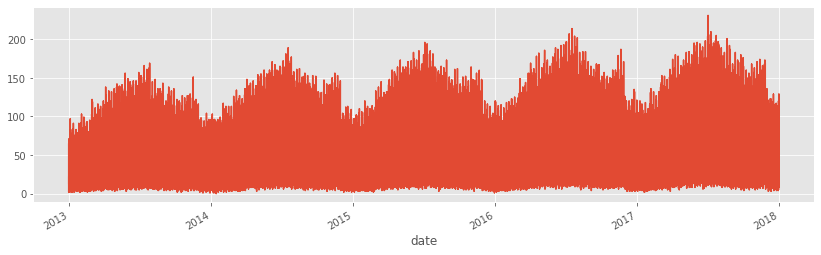

In [15]:
plt.figure(figsize=(14,4))
train.set_index('date')['sales'].plot(kind='line')

### 2.1 Sales

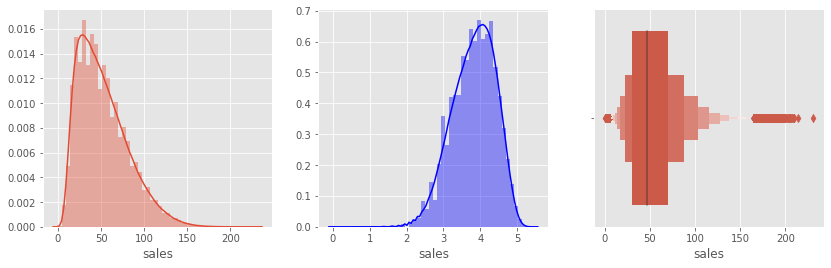

In [16]:
f,ax = plt.subplots(1,3,figsize=(14,4))
sns.distplot(train['sales'],ax =ax[0])
sns.distplot(np.log(train['sales']+1),ax=ax[1], color='b')
sns.boxenplot(train['sales'],ax =ax[2])

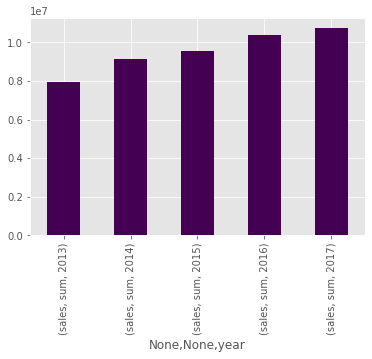

In [17]:
(train
 .groupby(['year',])
 .agg({'sales':['sum',]})
 .unstack()
 .plot(kind='bar',cmap='viridis'))

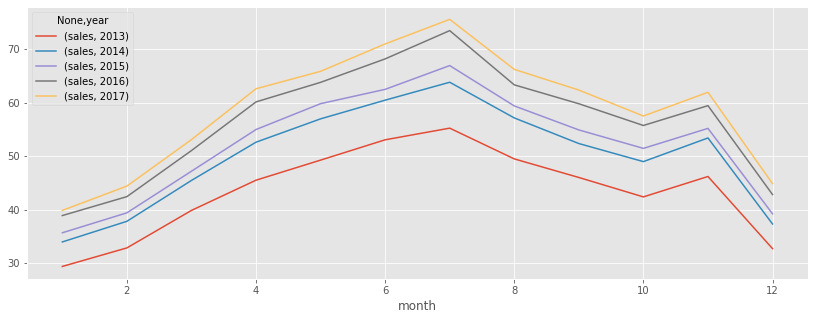

In [18]:
(train
 .groupby(['month','year'])
 .agg({'sales':'mean'})
 .unstack()
 .plot(figsize=(14,5)))

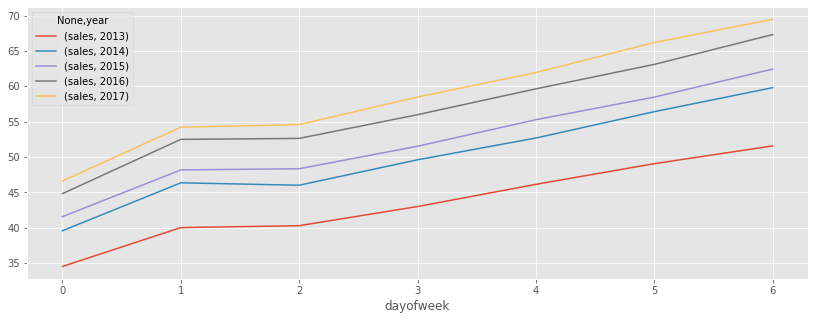

In [19]:
(train
 .groupby(['dayofweek','year'])
 .agg({'sales':'mean'})
 .unstack()
 .plot(figsize=(14,5)))

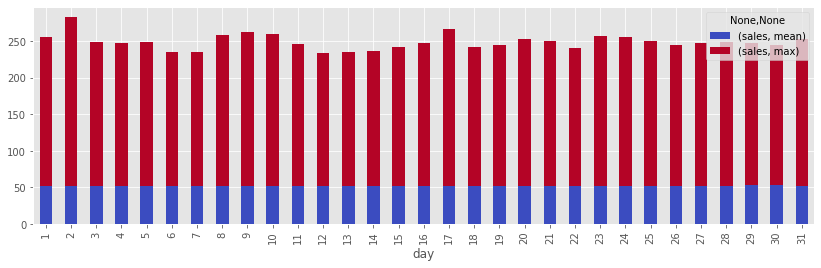

In [20]:
(train
.groupby(['day'])
.agg({'sales':['mean','max']})
.plot(figsize=(14,4),kind='bar',stacked=True,cmap='coolwarm'))

### 2.2 Aggregate sales statistics by day

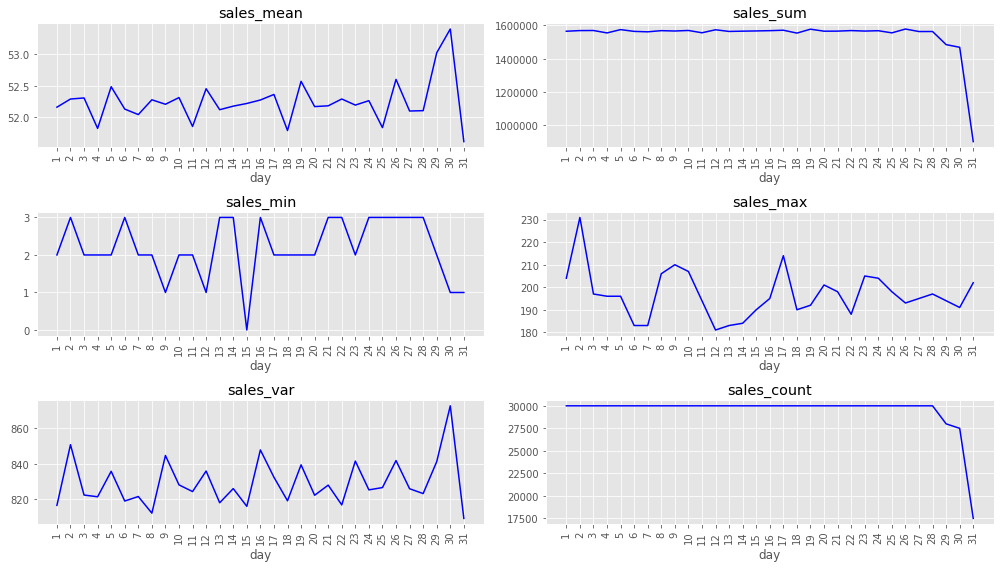

In [21]:
agg_stats(train,statistics=['mean','sum','min','max', 'var', 'count'],groupby_column=['day'])

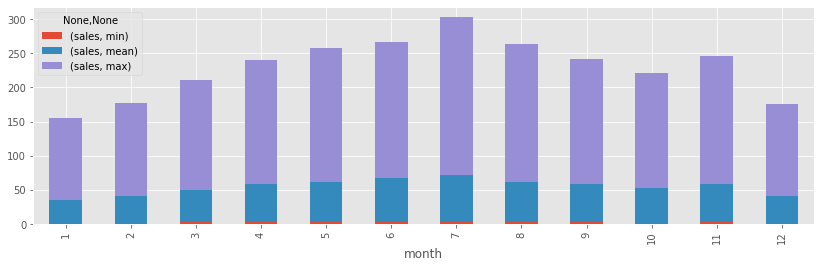

In [22]:
(train.groupby('month')
.agg({'sales':['min','mean','max']})
 .plot(figsize=(14,4),kind='bar',stacked=True))

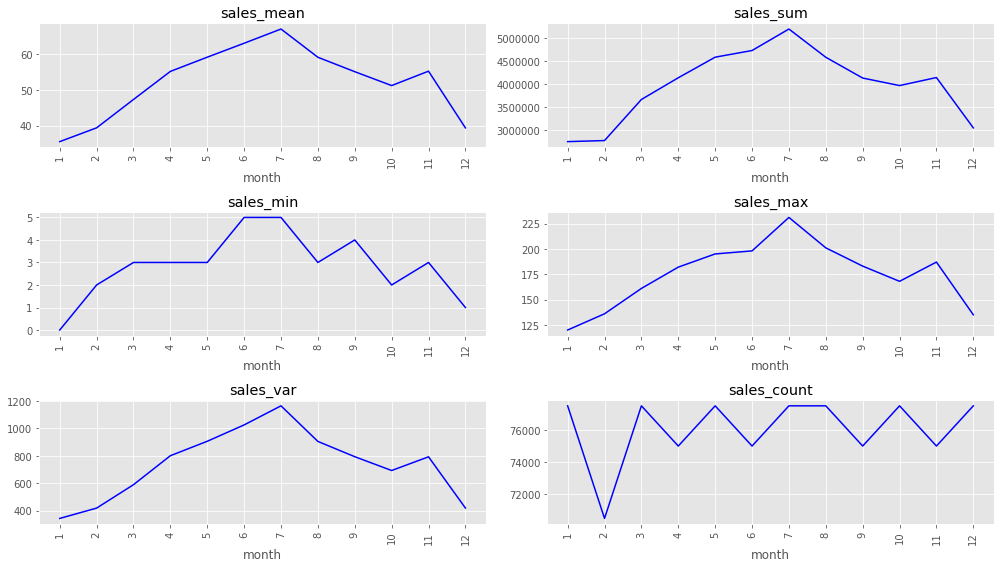

In [23]:
agg_stats(train,statistics=['mean','sum','min','max', 'var', 'count'],groupby_column=['month'])

### 2.3 Store

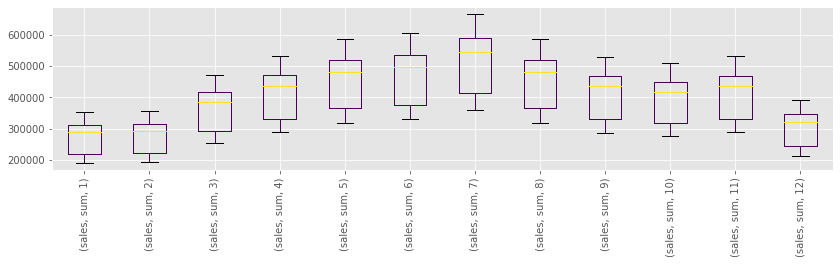

In [24]:
(train
 .groupby(['store','month'])
 .agg({'sales':['sum']})
 .unstack()
 .plot(figsize=(14,3),kind='box',stacked=True,cmap='viridis'))
plt.xticks(rotation=90);

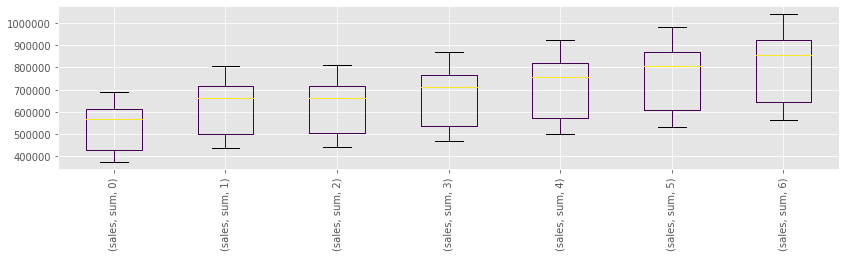

In [25]:
(train
 .groupby(['store','dayofweek'])
 .agg({'sales':['sum']})
 .unstack()
 .plot(figsize=(14,3),kind='box',stacked=True,cmap='viridis'))
plt.xticks(rotation=90);

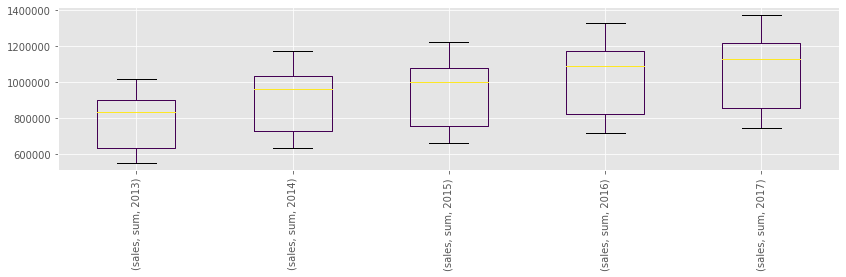

In [26]:
(train
 .groupby(['store','year'])
 .agg({'sales':['sum']})
 .unstack()
 .plot(figsize=(14,3),kind='box',stacked=True,cmap='viridis'))
plt.xticks(rotation=90);

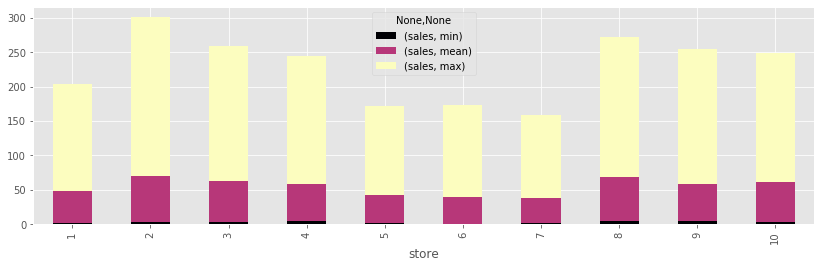

In [27]:
(train
 .groupby('store')
 .agg({'sales':['min','mean','max']})
 .plot(figsize=(14,4),kind='bar',stacked=True,cmap='magma'))

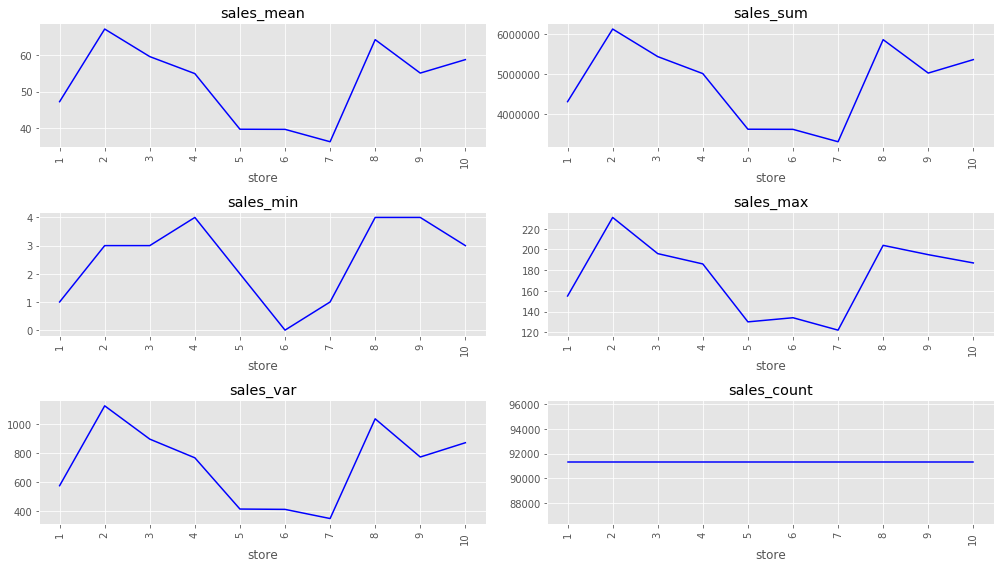

In [28]:
agg_stats(train,statistics=['mean','sum','min','max', 'var', 'count'],groupby_column=['store'])

### 2.4 item

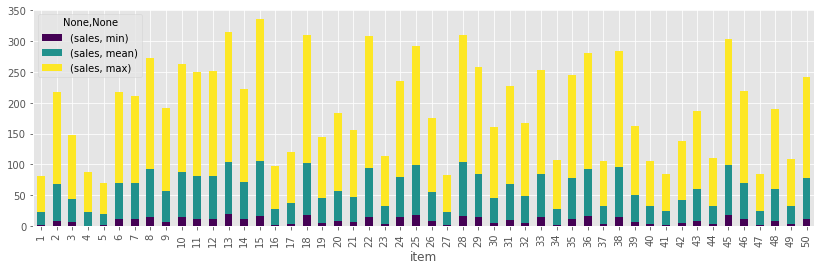

In [29]:
(train
 .groupby('item')
 .agg({'sales':['min','mean','max']})
 .plot(figsize=(14,4),kind='bar',stacked=True,cmap='viridis'))

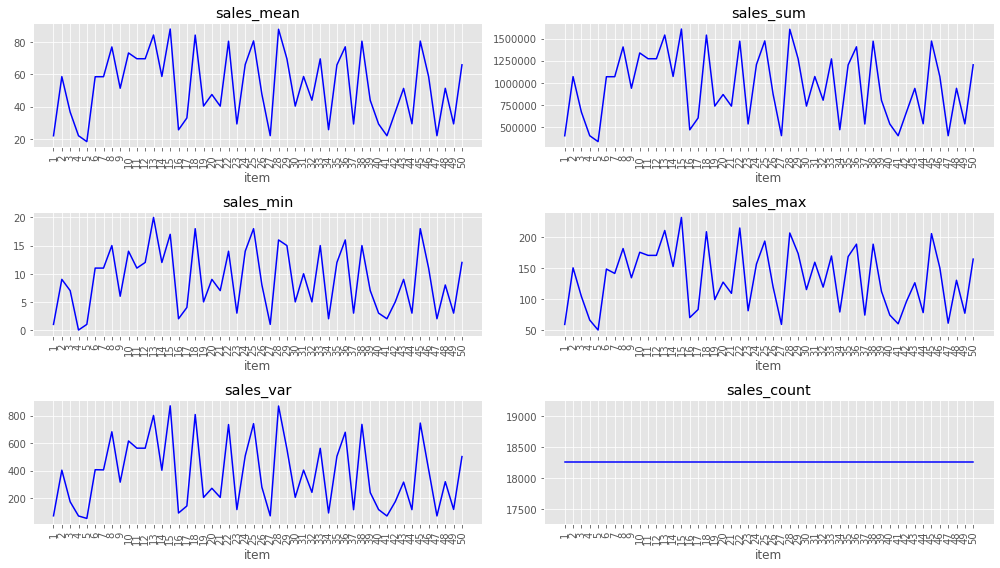

In [30]:
agg_stats(train,statistics=['mean','sum','min','max', 'var', 'count'],groupby_column=['item'])

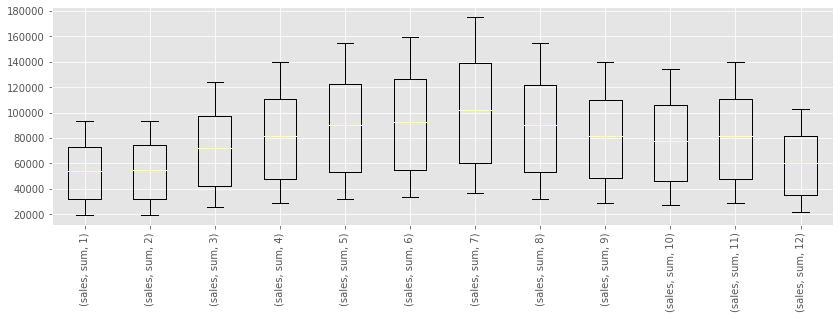

In [31]:
(train
 .groupby(['item','month'])
 .agg({'sales':['sum']})
 .unstack()
 .plot(figsize=(14,4),kind='box',stacked=True,cmap='magma'))
plt.xticks(rotation=90);

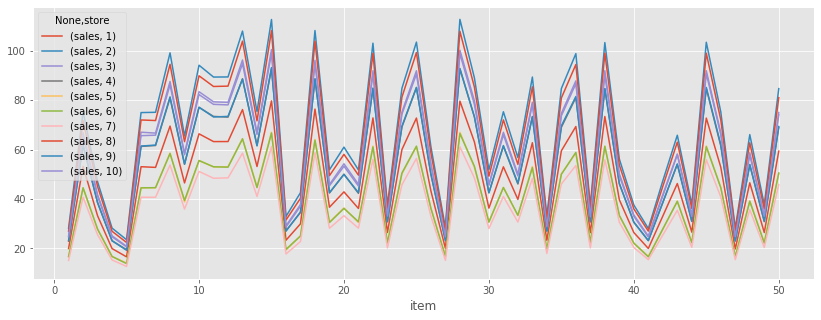

In [32]:
(train
 .groupby(['item','store'])
 .agg({'sales':'mean'})
 .unstack()
 .plot(figsize=(14,5),kind='line'))
plt.savefig('agg.png')

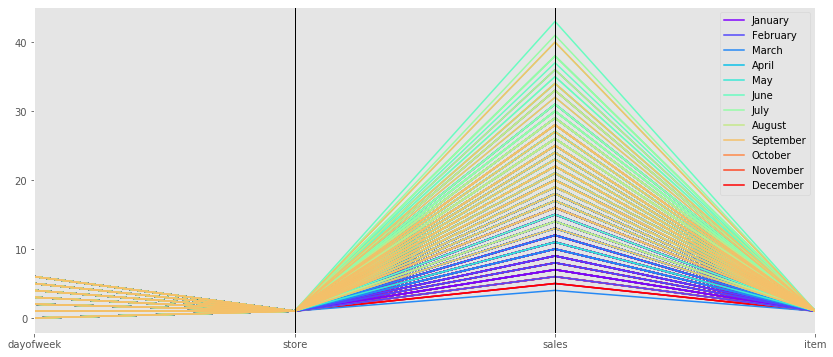

In [33]:
train1 =train.copy()
train1['month'] = train1['date'].dt.month_name()
plt.figure(figsize=(14,6))
pd.plotting.parallel_coordinates(train1[['dayofweek','store','sales','item','month']][:1000]
                                 ,'month',colormap='rainbow')
del train1

### 2.5 Rolling window

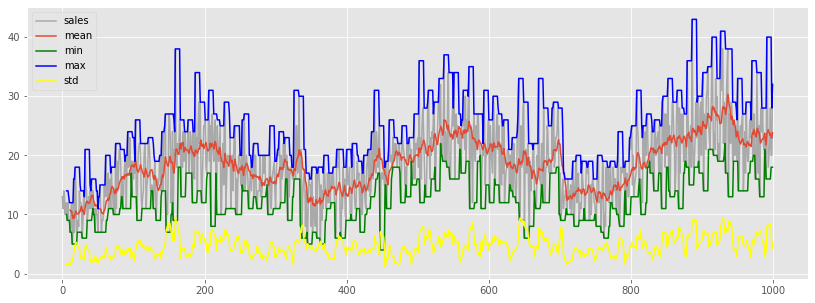

In [34]:
plt.figure(figsize=(14,5))
train['sales'].head(1000).plot(color='darkgray')
train['sales'].head(1000).rolling(window=12).mean().plot(label='mean')
#train['sales'].head(1000).rolling(window=12).median().plot(label='median')
train['sales'].head(1000).rolling(window=7).min().plot(label='min',color='g')
train['sales'].head(1000).rolling(window=7).max().plot(label='max',color='b')
train['sales'].head(1000).rolling(window=7).std().plot(label='std',color='yellow')
plt.legend()
#plt.savefig('Rolling window.png')

### 2.6 Expanding window

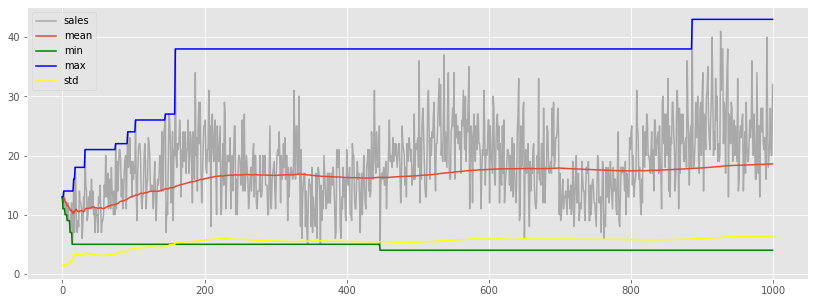

In [35]:
# Expanding window
plt.figure(figsize=(14,5))
train['sales'].head(1000).plot(color='darkgray')
train['sales'].head(1000).expanding().mean().plot(label='mean')
#train['sales'].head(1000).rolling(window=12).median().plot(label='median')
train['sales'].head(1000).expanding().min().plot(label='min',color='g')
train['sales'].head(1000).expanding().max().plot(label='max',color='b')
train['sales'].head(1000).expanding().std().plot(label='std',color='yellow')
plt.legend()

## 3.0 Data preprocessing

### 3.0 Aggregate / Rolling function

In [36]:
# Claculate groupby statics for lag date 
def calc_stats(df, end,window,groupby=None,aggregates='mean',value='sales'):
    
    # dates
    last_date = pd.to_datetime(end) - pd.Timedelta(days=1)
    first_date = pd.to_datetime(end) - pd.Timedelta(days= window)
    # Aggregate
    df1 = df[(df.date >=first_date) & (df.date<= last_date) ]
    df_agg = df1.groupby(groupby)[value].agg(aggregates)
    # Change name of columns
    df_agg.name =  str(end).split(' ')[0]+'_' + '_'.join(groupby)+'_'+aggregates+'_'+ str(window)
    return df_agg.reset_index()

#sales_by_store_item
def sales_by_store_item(df, end, aggregates='mean', value='sales'):
    
    print('Adding sales by store item')
    data = calc_stats(df,end, window=1,aggregates=aggregates, 
                      groupby=['store','item'], value=value)
    print('window 1 added')
    
    for window in  [3,7,14,28,90,180,365]:
        agg = calc_stats(df,end, window=window, aggregates=aggregates,
                         groupby=['store','item'], value=value )
        data = pd.merge(data,agg)
        print('window %d added'% window)
    return data

# sales by store item dayofweek
def sales_by_store_item_dayofweek(df, end, aggregates='mean', value='sales'):
    
    print('Adding sales by store item dayofweek')
    data = calc_stats(df,end, window=7, aggregates=aggregates,
                      groupby = ['store','item','dayofweek'], value=value)
    print('window 7 added')
    
    for window in  [14,28,28*2,28*3,28*6,28*12]:
        agg = calc_stats(df,end, window=window, aggregates=aggregates,
                         groupby=['store','item','dayofweek'], value=value )
        data = pd.merge(data,agg)
        print('window %d added'% window)
    return data

# sales_by_store_item_day
def sales_by_store_item_day(df, end, aggregates='mean', value='sales'):
    
    print('Adding sales by store item day')
    data = calc_stats(df,end, window=365, aggregates=aggregates,
                      groupby = ['store','item','day'], value=value)
    print('window 365 added')
    
    return data

# Sales by item
def sales_by_item(df, end, aggregates='mean', value='sales'):
    
    print('Adding sales by item ')
    data = calc_stats(df,end, window=7, aggregates=aggregates,
                      groupby = ['item'], value=value)
    print('window 7 added')
    
    for window in  [14,28,28*2]:
        agg = calc_stats(df,end, window=window, aggregates=aggregates,
                         groupby=['item'], value=value )
        data = pd.merge(data,agg)
        print('window %d added'% window)
    return data

In [37]:
def calc_roll_stat(df,end,groupby=None,window=1,aggregate='mean'):
    # Rolling statistics method
    last_date = pd.to_datetime(end) - pd.Timedelta(days=1)
    first_date = pd.to_datetime(end) - pd.Timedelta(days=window)
    df1 = df[(df.date >= first_date) & (df.date <= last_date)]
    
    dfPivot = df1.set_index(['date']+groupby)['sales'].unstack().unstack()
    dfPivot = dfPivot.rolling(window=window).mean().fillna(method='bfill')
    return dfPivot.stack().stack().rename(aggregate+str(window))

def calc_expand_stat(df,end,window=1,aggregate='mean'):
    # Expanding statistics method
    last_date = pd.to_datetime(end) - pd.Timedelta(days=1)
    first_date = pd.to_datetime(end) - pd.Timedelta(days=window)
    df1 = df[(df.date >= first_date) & (df.date <= last_date)]
    
    dfPivot = df1.set_index(['date','store','item'])['sales'].unstack().unstack()
    dfPivot = dfPivot.expanding(min_periods=window).mean().fillna(method='bfill')
    dfPivot = dfPivot.stack().stack().rename(aggregate+'_'+str(window)).reset_index()
    return dfPivot

def sales_by_store_item_expading(df,end,aggregate = 'mean', value = 'sales'):
    print('Adding sales by expanding')
    data =calc_expand_stat(df,end,window=3, aggregate='mean')
    return data
# https://stackoverflow.com/questions/25917287/pandas-groupby-expanding-mean-by-column-value

In [38]:
def create_data1(sales,test,date):
    
    # Date input
    for i in range(2):
        end = pd.to_datetime(date) - pd.Timedelta(days=7*i+1)
        print(end)
    
        # Rolling feature
        #for aggregates in ['mean','min','max','sum','std']:
        for aggregates in ['mean','sum']:

            # store/item
            print('-'*20+'Aggregate by '+aggregates+'-'*20)
            data = sales_by_store_item(sales,end, aggregates=aggregates,value='sales')
            sales = pd.merge(sales,data,on=['store','item'],how='left')
            test = pd.merge(test,data,on=['store','item'], how='left')

            # store/item/dayofweek
            df = sales_by_store_item_dayofweek(sales,end, aggregates=aggregates,value='sales')
            #data = pd.merge(data,df,)
            sales = pd.merge(sales,df,on=['store','item','dayofweek'],how='left')
            test = pd.merge(test,df,on=['store','item','dayofweek'], how='left')

            # store/item/day
            df = sales_by_store_item_day(sales,end, aggregates=aggregates,value='sales')
            #data = pd.merge(data,df)
            sales = pd.merge(sales,df,on=['store','item','day'],how='left')
            test = pd.merge(test,df,on=['store','item','day'], how='left')

            # sales/item
            df = sales_by_item(sales,end, aggregates=aggregates, value='sales')
            data = pd.merge(data,df)
            #data = pd.merge(sales,data)
            sales = pd.merge(sales,df, on=['item'],how='left')
            test = pd.merge(test,df, on=['item'], how='left')

    return sales,test

In [39]:
#Time series start time: "2013-01-01 00:00:00" and end time: "2017-12-31 00:00:00"
#Time series start time: "2018-01-01 00:00:00" and end time: "2018-03-31 00:00:00"
tes_start = '2018-01-01'

In [40]:
# Rolling aggregation or lag feature for diffirend window size
train1,test1 = create_data1(train,test,tes_start)

2017-12-31 00:00:00
--------------------Aggregate by mean--------------------
Adding sales by store item
window 1 added
window 3 added
window 7 added
window 14 added
window 28 added
window 90 added
window 180 added
window 365 added
Adding sales by store item dayofweek
window 7 added
window 14 added
window 28 added
window 56 added
window 84 added
window 168 added
window 336 added
Adding sales by store item day
window 365 added
Adding sales by item 
window 7 added
window 14 added
window 28 added
window 56 added
--------------------Aggregate by sum--------------------
Adding sales by store item
window 1 added
window 3 added
window 7 added
window 14 added
window 28 added
window 90 added
window 180 added
window 365 added
Adding sales by store item dayofweek
window 7 added
window 14 added
window 28 added
window 56 added
window 84 added
window 168 added
window 336 added
Adding sales by store item day
window 365 added
Adding sales by item 
window 7 added
window 14 added
window 28 added
window 

### 3.1 One hot encoding

In [41]:
train1['id'] = np.nan
train1['is_train'] = True
test1['is_train'] = False
test1['sales'] = np.nan

# concat train,test
train_test = pd.concat([train1,test1],axis=0)

#Log transform
train_test['sales_log'] = np.log(train_test['sales']+1)
gc.collect()
train_test.shape

def one_hot_encoding(df,columns):
    print('Original shape',df.shape)
    df = pd.get_dummies(df,drop_first=True,columns=columns)
    print('After OHE', df.shape)
    return df

In [42]:
gc.collect()
train_test = one_hot_encoding(train_test,columns=['month','dayofweek'])

Original shape (958000, 94)
After OHE (958000, 109)


In [43]:
reduce_memory_usage(train_test)

Intial memory usage: 676.0787963867188 MB
Memory usage after complition:  533.5540771484375 MB


In [44]:
#plt.figure(figsize=(14,10))
#sns.heatmap(train_test1.corr(), cmap='coolwarm', annot=True,fmt='.2f')

## 4.0 Model selection

In [45]:
# Model
col_drop = ['id','is_train','sales','sales_log']
X = train_test[train_test['is_train'] == True].drop(col_drop, axis=1)
y = train_test[train_test['is_train'] == True]['sales_log']
test_new = train_test[train_test['is_train'] == False].drop(col_drop +['date'],axis=1)

# Time series based split
#Time series start time: "2013-01-01 00:00:00" and end time: "2017-12-31 00:00:00"
#Time series start time: "2018-01-01 00:00:00" and end time: "2018-03-31 00:00:00"
tra_start, tra_end = '2013-01-01','2016-12-31'
val_start, val_end = '2017-01-01','2017-12-31'
tes_start = '2018-01-01'

X_train = X[X.date.isin(pd.date_range(tra_start,tra_end))].drop(['date'],axis=1)
X_valid = X[X.date.isin(pd.date_range(val_start, val_end))].drop(['date'],axis=1)
y_train = y[X.date.isin(pd.date_range(tra_start,tra_end))]
y_valid = y[X.date.isin(pd.date_range(val_start, val_end))]
gc.collect()
X.shape,test_new.shape

((913000, 105), (45000, 104))

In [46]:
# SMAPE Systematic mean absolute Persent error
def smape(y_true,y_pred):
    
    n = len(y_pred)
    masked_arr = ~((y_pred==0)&(y_true==0))
    y_pred, y_true = y_pred[masked_arr], y_true[masked_arr]
    nom = np.abs(y_true - y_pred)
    denom = np.abs(y_true) + np.abs(y_pred)
    smape = 200/n * np.sum(nom/denom)
    return smape
def lgb_smape(pred,train_data):
    ''' 
    Custom evaluvation function
    '''
    label = train_data.get_label()
    smape_val = smape(np.expm1(pred), np.expm1(label))
    return 'SMAPE',smape_val, False

## 5.0 Model

In [47]:
def lgb_model(X_train, X_valid, y_valid, y_test,test_new):
    lgb_param = {}
    lgb_param['boosting_type'] ='gbdt'
    lgb_param['max_depth'] = 7
    lgb_param['num_leaves'] = 2**7
    lgb_param['learning_rate'] = 0.05
    #lgb_param['n_estimators'] = 3000
    lgb_param['feature_fraction'] = 0.9
    lgb_param['bagging_fraction'] = 0.9
    lgb_param['lambda_l1'] = 0.06
    lgb_param['lambda_l2'] =  0.1
    lgb_param['random_state'] = seed
    lgb_param['n_jobs'] = 4
    lgb_param['silent'] = -1
    lgb_param['verbose'] = -1
    lgb_param['metric'] = 'mae'
    
    model = lgb.LGBMRegressor(**lgb_param)
    lgb_train = lgb.Dataset(X_train,y_train)
    lgb_valid = lgb.Dataset(X_valid,y_valid)
    valid_set = [lgb_train,lgb_valid]
    model = lgb.train(params=lgb_param,train_set=lgb_train,valid_sets=valid_set,num_boost_round= 300,
                      feval=lgb_smape,early_stopping_rounds=20,)
    print('-'*10,'*'*20,'-'*10)
    #model.fit(X_train,y_train, eval_set= [(X_train,y_train),(X_valid,y_valid)],
    #          eval_metric ='rmse',early_stopping_rounds=20,verbose=100)
    
    y_pred = model.predict(X_valid)
    print('Root mean_squared_error','-'*20 ,np.sqrt(mean_squared_error(y_valid, y_pred)))
    y_pred_new = model.predict(test_new)
    return y_pred_new, model

In [48]:
# Model training
y_pred_new, model = lgb_model(X_train, X_valid, y_valid, y_valid,test_new)

C:\ProgramData\Anaconda3\envs\tensorflow_env\lib\site-packages\lightgbm\basic.py:794: UserWarning: silent keyword has been found in `params` and will be ignored.
Please use silent argument of the Dataset constructor to pass this parameter.
  .format(key))


[1]	training's l1: 0.449862	training's SMAPE: 44.0816	valid_1's l1: 0.467346	valid_1's SMAPE: 45.697
Training until validation scores don't improve for 20 rounds
[2]	training's l1: 0.429565	training's SMAPE: 42.2474	valid_1's l1: 0.447381	valid_1's SMAPE: 43.8937
[3]	training's l1: 0.410545	training's SMAPE: 40.5112	valid_1's l1: 0.428788	valid_1's SMAPE: 42.2004
[4]	training's l1: 0.393274	training's SMAPE: 38.9201	valid_1's l1: 0.411537	valid_1's SMAPE: 40.6123
[5]	training's l1: 0.376008	training's SMAPE: 37.318	valid_1's l1: 0.394522	valid_1's SMAPE: 39.0348
[6]	training's l1: 0.359659	training's SMAPE: 35.7897	valid_1's l1: 0.378467	valid_1's SMAPE: 37.5354
[7]	training's l1: 0.344287	training's SMAPE: 34.3437	valid_1's l1: 0.363483	valid_1's SMAPE: 36.1288
[8]	training's l1: 0.329893	training's SMAPE: 32.9806	valid_1's l1: 0.349582	valid_1's SMAPE: 34.8166
[9]	training's l1: 0.316123	training's SMAPE: 31.6693	valid_1's l1: 0.335708	valid_1's SMAPE: 33.4981
[10]	training's l1: 0.3

[81]	training's l1: 0.124982	training's SMAPE: 12.8355	valid_1's l1: 0.123398	valid_1's SMAPE: 12.6155
[82]	training's l1: 0.124937	training's SMAPE: 12.831	valid_1's l1: 0.123232	valid_1's SMAPE: 12.5988
[83]	training's l1: 0.124895	training's SMAPE: 12.8268	valid_1's l1: 0.123098	valid_1's SMAPE: 12.5853
[84]	training's l1: 0.124855	training's SMAPE: 12.8228	valid_1's l1: 0.122937	valid_1's SMAPE: 12.5692
[85]	training's l1: 0.124819	training's SMAPE: 12.8192	valid_1's l1: 0.122797	valid_1's SMAPE: 12.5551
[86]	training's l1: 0.124785	training's SMAPE: 12.8159	valid_1's l1: 0.122675	valid_1's SMAPE: 12.5429
[87]	training's l1: 0.124752	training's SMAPE: 12.8126	valid_1's l1: 0.122547	valid_1's SMAPE: 12.53
[88]	training's l1: 0.124721	training's SMAPE: 12.8095	valid_1's l1: 0.122443	valid_1's SMAPE: 12.5196
[89]	training's l1: 0.124693	training's SMAPE: 12.8068	valid_1's l1: 0.122338	valid_1's SMAPE: 12.509
[90]	training's l1: 0.124665	training's SMAPE: 12.804	valid_1's l1: 0.122239	

[161]	training's l1: 0.123891	training's SMAPE: 12.7265	valid_1's l1: 0.120229	valid_1's SMAPE: 12.2974
[162]	training's l1: 0.123882	training's SMAPE: 12.7256	valid_1's l1: 0.120217	valid_1's SMAPE: 12.2962
[163]	training's l1: 0.123872	training's SMAPE: 12.7246	valid_1's l1: 0.120217	valid_1's SMAPE: 12.2961
[164]	training's l1: 0.123864	training's SMAPE: 12.7239	valid_1's l1: 0.120218	valid_1's SMAPE: 12.2962
[165]	training's l1: 0.123858	training's SMAPE: 12.7232	valid_1's l1: 0.120204	valid_1's SMAPE: 12.2948
[166]	training's l1: 0.123853	training's SMAPE: 12.7227	valid_1's l1: 0.120204	valid_1's SMAPE: 12.2948
[167]	training's l1: 0.123845	training's SMAPE: 12.7219	valid_1's l1: 0.120202	valid_1's SMAPE: 12.2946
[168]	training's l1: 0.12384	training's SMAPE: 12.7213	valid_1's l1: 0.120197	valid_1's SMAPE: 12.2942
[169]	training's l1: 0.123832	training's SMAPE: 12.7206	valid_1's l1: 0.120196	valid_1's SMAPE: 12.294
[170]	training's l1: 0.123826	training's SMAPE: 12.72	valid_1's l1

---------- ******************** ----------
Root mean_squared_error -------------------- 0.15497861699936316


### 6.0 Model evaluation

In [49]:
#print('Root mean_squared_error',np.sqrt(mean_squared_error(y_test, y_pred)))

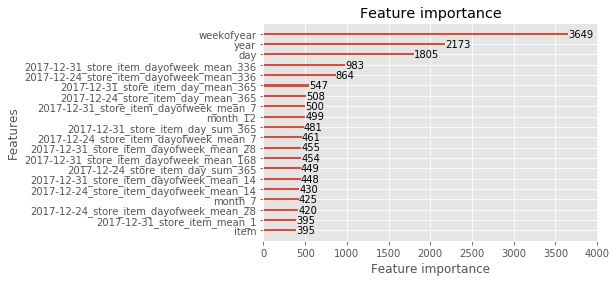

In [50]:
# Feature importance
lgb.plot_importance(model,max_num_features=20);

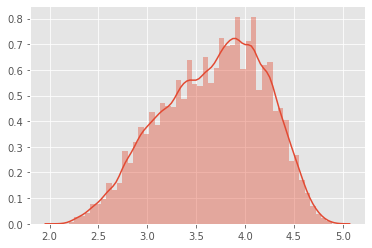

In [51]:
sns.distplot(y_pred_new)

In [52]:
y_pred_new1 = np.exp(y_pred_new)-1
submit = pd.DataFrame({'id': test['id'], 'sales':(y_pred_new1)})
submit.to_csv('store_submit.csv',index=False)
submit.head()

,id,sales
0,0,10.988229
1,1,12.870372
2,2,13.383260
3,3,14.168304
4,4,14.908286


## Thank you